In [1]:
import tensorflow as tf
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


In [2]:
!nvidia-smi

Tue Jul 25 09:10:34 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.26                 Driver Version: 375.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0     Off |                  N/A |
| 17%   48C    P8    15W / 200W |   8110MiB /  8113MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:03:00.0     Off |                  N/A |
| 18%   49C    P8    15W / 200W |   7924MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import pandas as pd
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

### Read the data

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
print(type(mnist.train.images))
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

<class 'numpy.ndarray'>
(55000, 784)
(55000, 10)


### Build the graph

* 1 Going forward

In [6]:
# data placeholder
x = tf.placeholder(tf.float32, [None, 784])

# weights and bias
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# logits
y = tf.matmul(x, W) + b

# placeholder for correct labels
y_ = tf.placeholder(tf.float32, [None, 10])

* 2 Labels' predictions, accuracy

In [7]:
labels_hat = tf.cast(tf.argmax(y, axis=1), tf.float32)
labels = tf.cast(tf.argmax(y_, axis=1), tf.float32)

In [8]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(labels_hat, labels), tf.float32))

* 3 Nn-training 

In [9]:
loss = tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_)
train_step = tf.train.AdamOptimizer().minimize(loss)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

* 4 Executing computations on the graph

In [11]:
test_accs = []

In [12]:
for i in range(300):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    test_xs, test_ys = mnist.test.next_batch(200)
    test_accs.append(sess.run(accuracy, feed_dict={x: test_xs, y_: test_ys}))

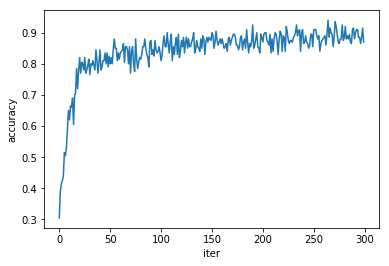

In [13]:
plt.plot(test_accs)
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.show()

### Is it the perfect way to build a tf-solution? No!

* We implicitly base the whole process on the way Jup Notebook stores local (for specific cells) variables
* E.g., it is only possible for us to train the model in item 4
* Because Jup Notebook stores in memory refs on placeholder defined in item 1
* Important idea: 
* When we create an op (as in item 1) we actually create $\textbf{two}$ objects:

1) python-ref on an op

2) tf-op stored in graph

* While the first are temporary, the second live forever!

### Building the tf-model in a better way: structuring the whole thing

* OK. Where are the tf-ops stored?

In [14]:
# fetch the link on default graph
grph = tf.get_default_graph()

In [15]:
# get all ops created in the graph
ops = grph.get_operations()

In [16]:
# (what a mess!)
ops

[<tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'zeros' type=Const>,
 <tf.Operation 'Variable' type=VariableV2>,
 <tf.Operation 'Variable/Assign' type=Assign>,
 <tf.Operation 'Variable/read' type=Identity>,
 <tf.Operation 'zeros_1' type=Const>,
 <tf.Operation 'Variable_1' type=VariableV2>,
 <tf.Operation 'Variable_1/Assign' type=Assign>,
 <tf.Operation 'Variable_1/read' type=Identity>,
 <tf.Operation 'MatMul' type=MatMul>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'ArgMax/dimension' type=Const>,
 <tf.Operation 'ArgMax' type=ArgMax>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'ArgMax_1/dimension' type=Const>,
 <tf.Operation 'ArgMax_1' type=ArgMax>,
 <tf.Operation 'Cast_1' type=Cast>,
 <tf.Operation 'Equal' type=Equal>,
 <tf.Operation 'Cast_2' type=Cast>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'Mean' type=Mean>,
 <tf.Operation 'Rank' type=Const>,
 <tf.Operation 'Shape' type=Shape>,
 <tf.Operation 'Ran

* That is, when we create ops
* ... we place them in the default graph.
* Obviously, not the best way to do things
* If we want to build, say, several models in one nb
* graph contexts help!

In [17]:
grapphy = tf.Graph()

In [18]:
with grapphy.as_default():
    xx = tf.placeholder(tf.float32, [None, 784])
    summy = tf.reduce_mean(xx, axis=1)
    

In [19]:
with grapphy.as_default():
    sess = tf.Session()
    batch_xs, batch_ys = mnist.train.next_batch(10)
    print(sess.run(summy, feed_dict={xx: batch_xs}))

[ 0.17054823  0.10235595  0.08560925  0.15968388  0.12482995  0.18528412
  0.17763607  0.12184375  0.229967    0.14185175]


In [20]:
grapphy.get_operations()

[<tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Mean/reduction_indices' type=Const>,
 <tf.Operation 'Mean' type=Mean>]

* Still, hard to trace the variables
* They're very miserable, let's give them a name!

In [32]:
grapphy = tf.Graph()
with grapphy.as_default():
    x = tf.placeholder(tf.float32, [None, 784], name='input_pics')
    W = tf.Variable(tf.random_normal([784, 10]), name='weights')
    b = tf.Variable(tf.zeros([10]), name='bias')
    logits = tf.matmul(x, W) + b
    logits = tf.identity(logits, 'logits')

In [33]:
grapphy.get_operations()

[<tf.Operation 'input_pics' type=Placeholder>,
 <tf.Operation 'random_normal/shape' type=Const>,
 <tf.Operation 'random_normal/mean' type=Const>,
 <tf.Operation 'random_normal/stddev' type=Const>,
 <tf.Operation 'random_normal/RandomStandardNormal' type=RandomStandardNormal>,
 <tf.Operation 'random_normal/mul' type=Mul>,
 <tf.Operation 'random_normal' type=Add>,
 <tf.Operation 'weights' type=VariableV2>,
 <tf.Operation 'weights/Assign' type=Assign>,
 <tf.Operation 'weights/read' type=Identity>,
 <tf.Operation 'zeros' type=Const>,
 <tf.Operation 'bias' type=VariableV2>,
 <tf.Operation 'bias/Assign' type=Assign>,
 <tf.Operation 'bias/read' type=Identity>,
 <tf.Operation 'MatMul' type=MatMul>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'logits' type=Identity>]

In [35]:
with grapphy.as_default():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    batch_xs, _ = mnist.train.next_batch(1)
    llogits = grapphy.get_tensor_by_name('logits:0')
    xx = grapphy.get_tensor_by_name('input_pics:0')
    print(sess.run(llogits, feed_dict={xx: batch_xs}))
    


[[ -2.82080245  -4.68091917 -17.47230339  -1.72977304  -3.8131094
    7.76443148   1.36736715   8.98284054 -12.5115633   -7.68815804]]


* what if we need to create several layers (e.g. fully-connected)? 
* we don't want to name vars 'weights_0', 'weights_1'...
* variable scopes can be of help!

In [24]:
def fc_layer(scope, input_layer, n_outs):
    """ Build fully-connected layer with n_outs outputs
    
    Args:
        input_layer: input layer
        n_outs: dim of output tensor
    Return:
        output layer (tf-tensor)
    """
    with tf.variable_scope(scope):
        W = tf.Variable(tf.random_normal([784, 10]), name='weights')
        b = tf.Variable(tf.zeros([10]), name='bias')
        output = tf.matmul(x, W) + b
        return output
    

### Structuring the whole thing

In [44]:
NUM_ITER = 1000
BATCH_SIZE = 500
grapphy = tf.Graph()
test_accs = []
with grapphy.as_default():
    # ph for feature-vector
    x = tf.placeholder(tf.float32, [None, 784], name='pics')
    # placeholder for correct labels
    y_ = tf.placeholder(tf.float32, [None, 10], name='labels')
    
    # build the net
    net = fc_layer('fc1', x, 300)
    net = fc_layer('fc2', net, 10)
    logits = tf.identity(net, 'logits')
    
    # loss
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_, name='loss')
    train_step = tf.train.AdamOptimizer().minimize(loss)
    
    # stats
    labels_hat = tf.cast(tf.argmax(logits, axis=1), tf.float32, name='labels_hat')
    labels = tf.cast(tf.argmax(y_, axis=1), tf.float32, name='labels')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(labels_hat, labels), tf.float32), name='acc')


In [37]:
grapphy.get_operations()

[<tf.Operation 'pics' type=Placeholder>,
 <tf.Operation 'labels' type=Placeholder>,
 <tf.Operation 'fc1/random_normal/shape' type=Const>,
 <tf.Operation 'fc1/random_normal/mean' type=Const>,
 <tf.Operation 'fc1/random_normal/stddev' type=Const>,
 <tf.Operation 'fc1/random_normal/RandomStandardNormal' type=RandomStandardNormal>,
 <tf.Operation 'fc1/random_normal/mul' type=Mul>,
 <tf.Operation 'fc1/random_normal' type=Add>,
 <tf.Operation 'fc1/weights' type=VariableV2>,
 <tf.Operation 'fc1/weights/Assign' type=Assign>,
 <tf.Operation 'fc1/weights/read' type=Identity>,
 <tf.Operation 'fc1/zeros' type=Const>,
 <tf.Operation 'fc1/bias' type=VariableV2>,
 <tf.Operation 'fc1/bias/Assign' type=Assign>,
 <tf.Operation 'fc1/bias/read' type=Identity>,
 <tf.Operation 'fc1/MatMul' type=MatMul>,
 <tf.Operation 'fc1/add' type=Add>,
 <tf.Operation 'fc2/random_normal/shape' type=Const>,
 <tf.Operation 'fc2/random_normal/mean' type=Const>,
 <tf.Operation 'fc2/random_normal/stddev' type=Const>,
 <tf.Oper

In [26]:
with grapphy.as_default():
    # train the net
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    for i in range(NUM_ITER):
        batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
        test_xs, test_ys = mnist.test.next_batch(BATCH_SIZE)
        test_accs.append(sess.run(accuracy, feed_dict={x: test_xs, y_: test_ys}))

### Save the model

In [27]:
with grapphy.as_default():
    saver = tf.train.Saver()
    saver.save(sess, 'trained/model')

In [40]:
import os
os.listdir('trained/')

['model.index', 'model.data-00000-of-00001', 'checkpoint', 'model.meta']

### Restore the model in different graph; running some ops

In [43]:
grapphy_2 = tf.Graph()
with grapphy_2.as_default():
    new_sess = tf.Session()
    new_saver = tf.train.import_meta_graph('trained/model.meta')
    new_saver.restore(new_sess, tf.train.latest_checkpoint('trained/'))

    # ph for feature-vector
    x = grapphy_2.get_tensor_by_name('pics:0')
    # placeholder for correct labels
    y_ = grapphy_2.get_tensor_by_name('labels:0')
    wghts = grapphy_2.get_tensor_by_name('fc1/weights:0')
    
    # acc
    accuracy = grapphy_2.get_tensor_by_name('acc:0')
    
    # run acc
    test_xs, test_ys = mnist.test.next_batch(10000)
    print(new_sess.run(accuracy, feed_dict={x: test_xs, y_: test_ys}))
    print(new_sess.run(wghts).shape)


INFO:tensorflow:Restoring parameters from trained/model
0.7906
(784, 10)


In [45]:
# not a mess anymore!
grapphy.get_operations()

[<tf.Operation 'pics' type=Placeholder>,
 <tf.Operation 'labels' type=Placeholder>,
 <tf.Operation 'fc1/random_normal/shape' type=Const>,
 <tf.Operation 'fc1/random_normal/mean' type=Const>,
 <tf.Operation 'fc1/random_normal/stddev' type=Const>,
 <tf.Operation 'fc1/random_normal/RandomStandardNormal' type=RandomStandardNormal>,
 <tf.Operation 'fc1/random_normal/mul' type=Mul>,
 <tf.Operation 'fc1/random_normal' type=Add>,
 <tf.Operation 'fc1/weights' type=VariableV2>,
 <tf.Operation 'fc1/weights/Assign' type=Assign>,
 <tf.Operation 'fc1/weights/read' type=Identity>,
 <tf.Operation 'fc1/zeros' type=Const>,
 <tf.Operation 'fc1/bias' type=VariableV2>,
 <tf.Operation 'fc1/bias/Assign' type=Assign>,
 <tf.Operation 'fc1/bias/read' type=Identity>,
 <tf.Operation 'fc1/MatMul' type=MatMul>,
 <tf.Operation 'fc1/add' type=Add>,
 <tf.Operation 'fc2/random_normal/shape' type=Const>,
 <tf.Operation 'fc2/random_normal/mean' type=Const>,
 <tf.Operation 'fc2/random_normal/stddev' type=Const>,
 <tf.Oper